In [230]:

import requests
from fake_useragent import UserAgent

ua = UserAgent()

URL_IMDB = "https://www.imdb.com/search/title/?title_type=feature&release_date=2018-01-01,2018-12-31"
headers = {
    "User-Agent": f"{ua.random}",
}
response = requests.get(URL_IMDB, headers=headers)

In [231]:
from bs4 import BeautifulSoup
import pandas as pd

# df = pd.DataFrame(columns=["id", "title", "duration", "gender_list", "release_date", "user_rating", "nb_user_rating"])

# film_dict = [{"id", "title", "duration", "gender_list", "release_date", "user_rating", "nb_user_rating"}]

soup = BeautifulSoup(response.text, "html.parser")
list_film_elem = soup.find("ul", class_="ipc-metadata-list--base")
list_film = list_film_elem.find_all("li", recursive=False)
len(list_film)

50

In [232]:
import re


def extract_id(link):
    regex = r"\/title\/tt(\d+)\/"
    match = re.search(regex, link)
    if match:
        return match.group(1)
    else:
        return None


In [233]:
import time
from tqdm.notebook import tqdm

extract_id(list_film[0].find("a", class_="ipc-title-link-wrapper").get("href"))
# extract_title(list_film[42].find("h3", class_="ipc-title__text").get_text(strip=True))
film_dict = []
for film in tqdm(list_film, total=len(list_film), desc="Films", unit="film", leave=True):
    time.sleep(1)
    response_film = requests.get(f"https://www.imdb.com{film.find('a', class_='ipc-title-link-wrapper').get('href')}",
                                 headers=headers)
    if response_film.status_code != 200:
        break
    soup_film = BeautifulSoup(response_film.text, "html.parser")
    _id = title = duration = gender_list = release_date = user_rating = nb_user_rating = None
    _id = extract_id(film.find("a", class_="ipc-title-link-wrapper").get("href"))
    if h1_title := soup_film.find("h1", {"data-testid": "hero__pageTitle"}):
        title = h1_title.find("span").get_text(strip=True)
    if li_duration := soup_film.find("li", {"data-testid": "title-techspec_runtime"}):
        duration = li_duration.find("div", class_="ipc-metadata-list-item__content-container").get_text(strip=True)
    if li_gender_list := soup_film.find("li", {"data-testid": "storyline-genres"}):
        if ul_gender_list := li_gender_list.find("ul",
                                                 class_="ipc-inline-list ipc-inline-list--show-dividers ipc-inline-list--inline ipc-metadata-list-item__list-content base"):
            gender_list = []
            for li_gender in ul_gender_list.find_all('li', recursive=False):
                gender_list.append(li_gender.find("a").get_text(strip=True))
    if li_release_date := soup_film.find("li", {"data-testid": "title-details-releasedate"}):
        if a_release_date := li_release_date.find("a", class_="ipc-metadata-list-item__list-content-item"):
            release_date = a_release_date.get_text(strip=True)
    if div_user_rating := soup_film.find("div", {"data-testid": "hero-rating-bar__aggregate-rating__score"}):
        user_rating = div_user_rating.find("span").get_text()
        nb_user_rating = div_user_rating.parent.find_all('div')[-1].get_text()
    film_dict.append({
        "id": _id,
        "title": title,
        "duration": duration,
        "gender_list": gender_list,
        "release_date": release_date,
        "user_rating": user_rating,
        "nb_user_rating": nb_user_rating
    })

df = pd.DataFrame(film_dict)
df.to_csv("../data/imdb.csv", index=False)
df.head()

Films:   0%|          | 0/50 [00:00<?, ?film/s]

,id,title,duration,gender_list,release_date,user_rating,nb_user_rating
0,4633694,Spider-Man: Into the Spider-Verse,1hour57minutes,None,"December 14, 2018 (Canada)",8.4,641K
1,7784604,Hereditary,2hours7minutes,None,"June 8, 2018 (Canada)",7.3,362K
2,5814060,The Nun,1hour36minutes,None,"September 7, 2018 (Canada)",5.3,165K
3,2709692,Dr. Seuss' the Grinch,1hour25minutes,None,"November 9, 2018 (Canada)",6.4,81K
4,4154756,Avengers: Infinity War,2hours29minutes,None,"April 27, 2018 (Canada)",8.4,1.2M


## 2. 2 Exploitation des donn´ees
### 2.1 Nettoyer et coder vos donn´ees : correction d’erreurs, traitement de valeurs manquantes s’il y a lieu, ´eliminations des duplications, ´eliminations des lignes avec des valeurs ab´erantes, et correction du type des donn´ees (codage si c’est n´ecessaire).

In [364]:
df = pd.read_csv("../data/movie_data.csv")
df.head()

,index,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie,date_ext
0,0,Black Panther,7.3,Action Adventure Sci-Fi,134.0,tt1825683,758827,(2018),"February 16, 2018"
1,1,Hereditary,7.3,Drama Horror Mystery,127.0,tt7784604,314486,(2018),"June 8, 2018"
2,2,Mile 22,6.1,Action Thriller,94.0,tt4560436,80168,(2018),"August 17, 2018"
3,3,Avengers: Infinity War,8.4,Action Adventure Sci-Fi,149.0,tt4154756,1069513,(2018),"April 27, 2018"
4,4,Suspiria,6.7,Drama Fantasy Horror,152.0,tt1034415,78980,(I) (2018),"November 2, 2018"


In [365]:
df.drop(columns=['index'], inplace=True)
df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie,date_ext
0,Black Panther,7.3,Action Adventure Sci-Fi,134.0,tt1825683,758827,(2018),"February 16, 2018"
1,Hereditary,7.3,Drama Horror Mystery,127.0,tt7784604,314486,(2018),"June 8, 2018"
2,Mile 22,6.1,Action Thriller,94.0,tt4560436,80168,(2018),"August 17, 2018"
3,Avengers: Infinity War,8.4,Action Adventure Sci-Fi,149.0,tt4154756,1069513,(2018),"April 27, 2018"
4,Suspiria,6.7,Drama Fantasy Horror,152.0,tt1034415,78980,(I) (2018),"November 2, 2018"


In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12909 entries, 0 to 12908
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   titre_film             12909 non-null  object 
 1   utilisateur_note       7642 non-null   float64
 2   genres_liste           12189 non-null  object 
 3   duree                  9772 non-null   float64
 4   id_film                12909 non-null  object 
 5   nbre_utilisateur_note  7645 non-null   object 
 6   date_sortie            12840 non-null  object 
 7   date_ext               12909 non-null  object 
dtypes: float64(2), object(6)
memory usage: 806.9+ KB


In [367]:
df.describe()

,utilisateur_note,duree
count,7642.000000,9772.000000
mean,5.859827,96.861543
std,1.435517,28.714294
min,1.000000,2.000000
25%,5.000000,83.000000
50%,6.000000,93.000000
75%,6.800000,109.000000
max,10.000000,808.000000


In [368]:
df.dtypes

titre_film                object
utilisateur_note         float64
genres_liste              object
duree                    float64
id_film                   object
nbre_utilisateur_note     object
date_sortie               object
date_ext                  object
dtype: object

In [369]:
df.isna().sum()

titre_film                  0
utilisateur_note         5267
genres_liste              720
duree                    3137
id_film                     0
nbre_utilisateur_note    5264
date_sortie                69
date_ext                    0
dtype: int64

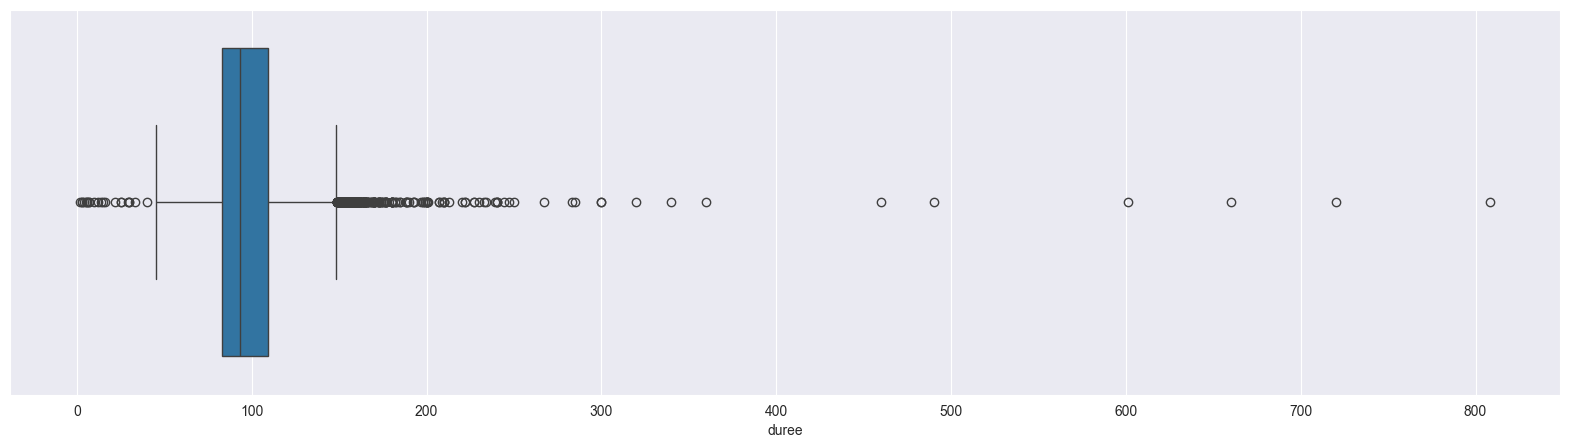

In [370]:
#box plot duree
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
sns.boxplot(x=df['duree'])
plt.show()

In [371]:
def delete_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    print(df.shape[0] - df[(df[col] > (q1 - 1.5 * iqr)) & (df[col] < (q3 + 1.5 * iqr))].shape[0], "outliers")
    df = df[(df[col] > (q1 - 1.5 * iqr)) & (df[col] < (q3 + 1.5 * iqr))]
    return df

In [372]:
df = delete_outliers(df, 'duree')

3505 outliers


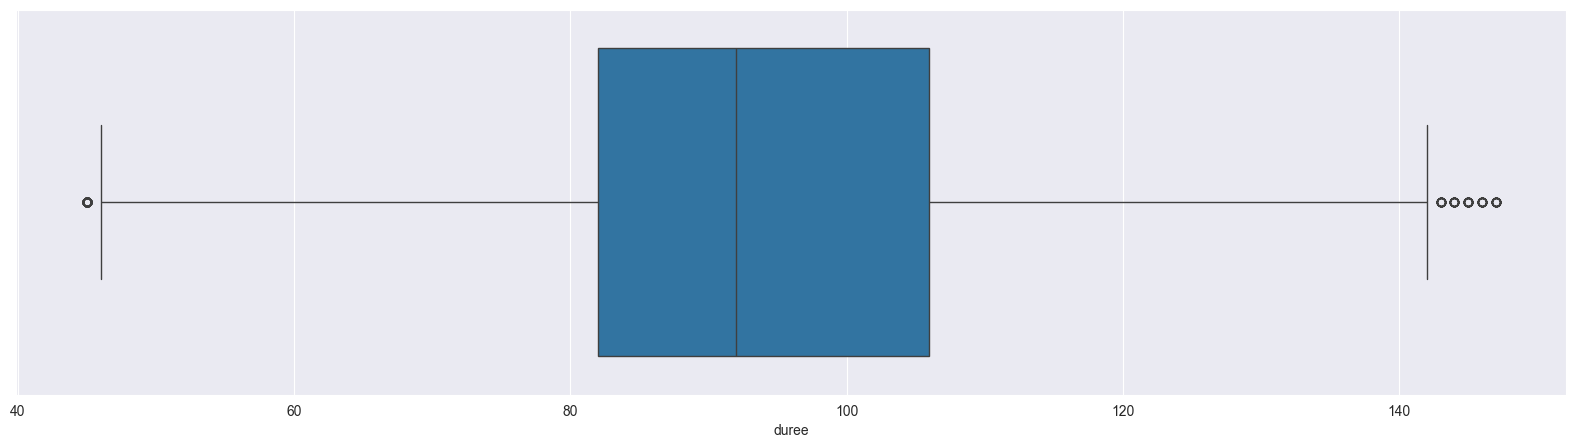

In [373]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=df['duree'])
plt.show()

In [374]:
import numpy as np


def convert_nb_user_rating(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, int):
        return value
    try:
        return int(value)
    except ValueError:
        return np.nan

In [375]:
df['nbre_utilisateur_note'] = df['nbre_utilisateur_note'].apply(convert_nb_user_rating)
df['nbre_utilisateur_note'].fillna(df['nbre_utilisateur_note'].median(), inplace=True)
df = delete_outliers(df, 'nbre_utilisateur_note')
df = df.astype({'nbre_utilisateur_note': 'int64'})
df.dtypes


1557 outliers


titre_film                object
utilisateur_note         float64
genres_liste              object
duree                    float64
id_film                   object
nbre_utilisateur_note      int64
date_sortie               object
date_ext                  object
dtype: object

In [376]:
def split_genre(value):
    if pd.isna(value):
        return []
    return value.split('  ')


split_genre('Action  Adventure  Sci-Fi')

['Action', 'Adventure', 'Sci-Fi']

In [377]:
df['genres_liste'] = df['genres_liste'].apply(lambda x: split_genre(x))
df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie,date_ext
102,Strangeways Here We Come,5.1,"[Comedy, Crime]",86.0,tt4299774,334,(2018),"October 5, 2018"
258,Virndavani Vairagya,6.6,[Drama],91.0,tt9675282,25,(2018),"April 3, 2018"
259,Dirty Work,3.3,"[Drama, Romance, Thriller]",73.0,tt7243754,380,(2018),"February 3, 2018"
280,Peripheral,4.8,"[Horror, Sci-Fi]",89.0,tt5658672,224,(I) (2018),"August 3, 2020"
297,Mar,5.5,[Drama],103.0,tt7490386,49,(I) (2018),"May 16, 2019"


In [378]:
top_5_genres = df['genres_liste'].explode().value_counts().head(5).index
for genre in top_5_genres:
    df[genre] = df['genres_liste'].apply(lambda x: 1 if genre in x else 0)


def other_genres(row):
    return 1 if any(genre not in top_5_genres for genre in row) else 0


df['autres_genres'] = df['genres_liste'].apply(other_genres)

df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_sortie,date_ext,Drama,Comedy,Thriller,Horror,Romance,autres_genres
102,Strangeways Here We Come,5.1,"[Comedy, Crime]",86.0,tt4299774,334,(2018),"October 5, 2018",0,1,0,0,0,1
258,Virndavani Vairagya,6.6,[Drama],91.0,tt9675282,25,(2018),"April 3, 2018",1,0,0,0,0,0
259,Dirty Work,3.3,"[Drama, Romance, Thriller]",73.0,tt7243754,380,(2018),"February 3, 2018",1,0,1,0,1,0
280,Peripheral,4.8,"[Horror, Sci-Fi]",89.0,tt5658672,224,(I) (2018),"August 3, 2020",0,0,0,1,0,1
297,Mar,5.5,[Drama],103.0,tt7490386,49,(I) (2018),"May 16, 2019",1,0,0,0,0,0


In [382]:
df.drop(columns=['date_sortie'], inplace=True)
df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_ext,Drama,Comedy,Thriller,Horror,Romance,autres_genres
102,Strangeways Here We Come,5.1,"[Comedy, Crime]",86.0,tt4299774,334,"October 5, 2018",0,1,0,0,0,1
258,Virndavani Vairagya,6.6,[Drama],91.0,tt9675282,25,"April 3, 2018",1,0,0,0,0,0
259,Dirty Work,3.3,"[Drama, Romance, Thriller]",73.0,tt7243754,380,"February 3, 2018",1,0,1,0,1,0
280,Peripheral,4.8,"[Horror, Sci-Fi]",89.0,tt5658672,224,"August 3, 2020",0,0,0,1,0,1
297,Mar,5.5,[Drama],103.0,tt7490386,49,"May 16, 2019",1,0,0,0,0,0


In [386]:
df['date_ext'] = pd.to_datetime(df['date_ext'], format='%B %d, %Y', errors='coerce')
df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_ext,Drama,Comedy,Thriller,Horror,Romance,autres_genres
102,Strangeways Here We Come,5.1,"[Comedy, Crime]",86.0,tt4299774,334,2018-10-05,0,1,0,0,0,1
258,Virndavani Vairagya,6.6,[Drama],91.0,tt9675282,25,2018-04-03,1,0,0,0,0,0
259,Dirty Work,3.3,"[Drama, Romance, Thriller]",73.0,tt7243754,380,2018-02-03,1,0,1,0,1,0
280,Peripheral,4.8,"[Horror, Sci-Fi]",89.0,tt5658672,224,2020-08-03,0,0,0,1,0,1
297,Mar,5.5,[Drama],103.0,tt7490386,49,2019-05-16,1,0,0,0,0,0


### 2.2 Cr´eer 2 nouvelles colonnes dur´ee minutes log, nbre utilisateur note log.

• Appliquer la fonction logarithmique sur la colonne dur´ee pour avoir la nouvelle colonne dur´ee minutes log.

• Appliquer la fonction logarithmique sur la colonne nbre utilisateur note pour avoir la nouvelle colonne nbre utilisateur note log.

In [391]:
df['duree_log'] = np.log(df['duree'])
df['nbre_utilisateur_note_log'] = np.log(df['nbre_utilisateur_note'])
df.head()

,titre_film,utilisateur_note,genres_liste,duree,id_film,nbre_utilisateur_note,date_ext,Drama,Comedy,Thriller,Horror,Romance,autres_genres,duree_log,nbre_utilisateur_note_log
102,Strangeways Here We Come,5.1,"[Comedy, Crime]",86.0,tt4299774,334,2018-10-05,0,1,0,0,0,1,4.454347,5.811141
258,Virndavani Vairagya,6.6,[Drama],91.0,tt9675282,25,2018-04-03,1,0,0,0,0,0,4.510860,3.218876
259,Dirty Work,3.3,"[Drama, Romance, Thriller]",73.0,tt7243754,380,2018-02-03,1,0,1,0,1,0,4.290459,5.940171
280,Peripheral,4.8,"[Horror, Sci-Fi]",89.0,tt5658672,224,2020-08-03,0,0,0,1,0,1,4.488636,5.411646
297,Mar,5.5,[Drama],103.0,tt7490386,49,2019-05-16,1,0,0,0,0,0,4.634729,3.891820


### 2.3 R´ealiser une analyse univari´ee compl`ete avec les visualisations ad´equates et interpr´eter les r´esultats.

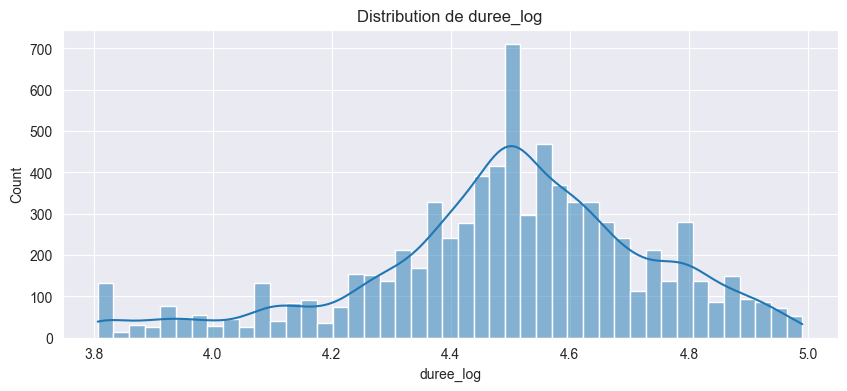

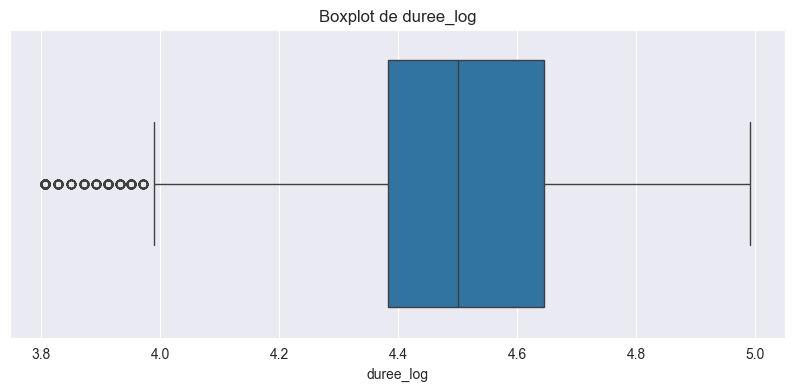

count    7847.000000
mean        4.496131
std         0.240010
min         3.806662
25%         4.382027
50%         4.499810
75%         4.644391
max         4.990433
Name: duree_log, dtype: float64


In [393]:
# Analyse d'une variable numérique
plt.figure(figsize=(10, 4))
sns.histplot(df['duree_log'], kde=True)
plt.title('Distribution de duree_log')
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['duree_log'])
plt.title('Boxplot de duree_log')
plt.show()

# Afficher les statistiques descriptives
print(df['duree_log'].describe())

L'histogramme montre la distribution des valeurs logarithmiques de la durée des films. La courbe en cloche superposée suggère que la distribution des logarithmes des durées est relativement symétrique et pourrait suivre une distribution normale, ce qui est souvent le cas après une transformation logarithmique lorsque les données originales sont biaisées. La concentration des données autour de la moyenne indique qu'il existe une durée de film typique lorsqu'on considère le logarithme de la durée.
Le boxplot montre également la distribution des valeurs logarithmiques de la durée. La boîte représente l'étendue interquartile (IQR), avec la ligne médiane indiquant la médiane des données. Les moustaches s'étendent jusqu'aux valeurs les plus éloignées dans l'IQR, et les points en dehors de cela sont considérés comme des valeurs aberrantes. Le boxplot montre quelques valeurs aberrantes sur le côté inférieur, indiquant quelques films avec des durées exceptionnellement courtes.
Les statistiques descriptives montrent que la moyenne des valeurs logarithmiques est d'environ 4.46, avec un écart-type d'environ 0.24, ce qui indique une variabilité modérée autour de la moyenne. Le minimum et le maximum sont respectivement de 3.86 et de près de 5.0, ce qui montre l'étendue des données.

En résumé, ces visualisations et statistiques fournissent une vue complète de la distribution logarithmique de la durée des films. La transformation logarithmique semble avoir normalisé la distribution, ce qui peut être utile pour des analyses statistiques qui supposent une normalité des données, comme de nombreux tests paramétriques. Les valeurs aberrantes basses pourraient être dû à des erreurs de données ou à des films particulièrement courts qui peuvent mériter une enquête supplémentaire.

### 2.4 R´ealiser une analyse bivari´ee compl`ete avec les visualisations ad´equates et interpr´eter les r´esultats.